### Assignment 2 - Collective communications


by Généreux M. AKOTENOU

In [1]:
"""
En exécutant tout ce notebook, le dossier 'genereux_akotenou1' sera créé et il contiendra les fichiers Python de chaque exercice.
On pourra par la suite utiliser la commande suivante pour exécuter chaque script et voir les sorties :

$ mpirun -n <number> python3 <filename.py>
"""
import os
directory = 'genereux_akotenou2'
if not os.path.exists(directory):
    os.makedirs(directory)

* EXO1

In [2]:
%%file genereux_akotenou2/exo1.py

from mpi4py import MPI
import numpy as np
import random
import time

# Initialize shared comm utils
COMM = MPI.COMM_WORLD
SIZE = COMM.Get_size()
RANK = COMM.Get_rank()

# Function
def compute_points(INTERVAL):
    random.seed(42)  
    circle_points= 0

    # Total Random numbers generated= possible x 
    # values* possible y values 
    for i in range(INTERVAL**2): 
        rand_x= random.uniform(-1, 1) 
        rand_y= random.uniform(-1, 1) 
      
        # Distance between (x, y) from the origin 
        origin_dist=np.sqrt(rand_x**2 + rand_y**2)
      
        # Checking if (x, y) lies inside the circle 
        if origin_dist<= 1: 
            circle_points+= 1
    
    return circle_points

# Data
N = 3250

# MAIN
if RANK == 0:
    t = time.time()
    sliced_interval = [N//SIZE for _ in range(SIZE)]
    sliced_interval[0] = sliced_interval[0]+(N % SIZE)
    sum_of_point = sum([i**2 for i in sliced_interval])
else:
    sliced_interval = None

recvbuff = COMM.scatter(sliced_interval, root=0)
local_circle_points = compute_points(recvbuff)

COMM.Barrier()

circle_points = COMM.reduce(local_circle_points, op=MPI.SUM, root=0)
if RANK == 0:
    print(f"Total circle points: {circle_points} OVER {sum_of_point} points")
    print(f"[TIME]: {time.time()-t}s")
    print(f"[PI  ]: {4*circle_points/sum_of_point}")

Writing genereux_akotenou2/exo1.py


In [ ]:
!mpirun -n 4 python3 genereux_akotenou2/exo1.py

In [16]:
# OUTPUT
# % mpirun -n 4 python3 exo1.py
#
# Total circle points: 2073481 OVER 2640628 points
# [TIME]: 0.5947270393371582s
# [PI  ]: 3.140890727508759

* EXO2

In [7]:
%%file genereux_akotenou2/exo2.py

from mpi4py import MPI
import numpy as np
import pandas as pd
from sympy import sympify
from sklearn.model_selection import train_test_split
import math
import matplotlib.pyplot as plt

# Initialize comm utils
COMM = MPI.COMM_WORLD
SIZE = COMM.Get_size()
RANK = COMM.Get_rank()

# Data generator
def generate_dataset(relation="2*x1 + 3*x2 - 9*x3", n_samples=100, with_noise=True, random_state=None) -> pd.DataFrame:
    if random_state:
        np.random.seed(random_state)

    # Parse the relation string
    expr = sympify(relation)
    variables = expr.free_symbols

    # Generate feature and target
    X = np.random.rand(n_samples, len(variables))
    coefficients = [expr.coeff(v) for v in variables]
    noise = np.random.randn(n_samples) * 0.1 if with_noise else 0
    y = np.dot(X, coefficients) + noise

    # Create DataFrame
    columns = [f"x{i+1}" for i in range(len(variables))]
    data = pd.DataFrame(X, columns=columns)
    data['y'] = y
    return data

# Parallel Regressor
class LinearRegressionSGD:
    def __init__(self, learning_rate=0.01, n_epochs=1000, random_state=None, batch_size=1): 
        self.learning_rate = learning_rate
        self.n_epochs = n_epochs
        self.random_state = random_state
        if self.random_state:
            np.random.seed(self.random_state)
        self.weights = None
        self.bias = None
        self.J_history = []
        self.weights_history = []
        self.batch_size = batch_size
        self.computation_time = 0

    def compute_cost(self, X, y, w, b):
        m = X.shape[0]
        cost_i = np.dot(w, X.T) + b - y
        return 1/(2*m) * np.dot(cost_i, cost_i.T)
    
    def compute_gradient(self, X, y, w, b, m):
        #m = X.shape[0]
        predictions = np.dot(w, X.T) + b
        errors = predictions - y.T
        dJ_w = 1/m * np.dot(errors, X)
        dJ_b = 1/m * np.sum(errors)
        return dJ_w.flatten(), dJ_b
    
    def fit(self, X, y, verbose=True):
        self.computation_time = MPI.Wtime()
        X = X.to_numpy()
        y = y.to_numpy()

        # initilization
        n_samples, n_features = X.shape
        self.weights = np.random.randn(n_features)
        self.bias = np.random.randn()

        # concatenate training set
        rng = np.random.default_rng(seed=self.random_state)
        train_set = np.c_[X.reshape(n_samples, -1), y.reshape(n_samples, 1)]
        m = train_set.shape[0]

        for i in range(self.n_epochs):
            # shuffle training set
            rng.shuffle(train_set)

            # Split data
            if RANK == 0:
                training_batch = np.array_split(train_set, SIZE, axis=0)
            else:
                training_batch = None
            local_training_set = COMM.scatter(sendobj=training_batch, root=0)
            
            # Slip target and features locally
            X_batch, y_batch = local_training_set[:, :-1], local_training_set[:, -1:]

            # Compute local gradient
            dJ_w_loc, dJ_b_loc = self.compute_gradient(X_batch, y_batch, self.weights, self.bias, m)

            # Sum all gradient and Update weights
            COMM.Barrier()
            dJ_w = COMM.allreduce(dJ_w_loc, op=MPI.SUM)
            dJ_b = COMM.allreduce(dJ_b_loc, op=MPI.SUM)
            self.weights = self.weights - self.learning_rate * dJ_w
            self.bias    = self.bias - self.learning_rate * dJ_b

            # Save cost at each iteration
            if RANK==0:
                if i<1000:
                    cost_J =  self.compute_cost(X, y, self.weights, self.bias)
                    self.J_history.append(cost_J)

                # Print cost every at intervals 10 times
                if verbose and i%math.ceil(self.n_epochs/10) == 0:
                    self.weights_history.append(self.weights)
                    print(f"Epoch: [{i}{' '*(len(str(self.n_epochs))-len(str(i)))}/{self.n_epochs}]\t Cost: {float(self.J_history[-1]):8.2f}\t weights: {self.weights_history[-1]}")

        # Timeit
        self.computation_time = MPI.Wtime() - self.computation_time
                        
    def predict(self, X):
        if RANK==0:
            X = X.to_numpy()
            predictions = np.dot(X, self.weights) + self.bias
            return pd.DataFrame(predictions)
    
    def summary(self):
        if RANK==0:
            print("\nMODEL SUMMARY:")
            print(f"Computation time: {self.computation_time}")
            print(f"Nbr Processor\t: {SIZE}")
            print(f"Learning Rate\t: {self.learning_rate}")
            print(f"Number of Epochs: {self.n_epochs}")
            print(f"Model Weights\t: {self.weights}")
            print(f"Model Bias\t: {self.bias}")
            # Plot
            plt.plot(range(self.n_epochs), self.J_history)
            plt.title('Cost Function Over Epochs')
            plt.xlabel('Epochs')
            plt.ylabel('Cost')
            plt.savefig('cost_function_over_epochs.png')
            plt.show()

# Synthetic dataset
dataset = generate_dataset(relation="2*x1 - 9*x2", n_samples=10000, with_noise=True, random_state=42)
X = dataset.drop(columns=['y'])
y = dataset['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Main
model = LinearRegressionSGD(learning_rate=0.1, n_epochs=1000, random_state=42)
model.fit(X_train, y_train)
model.summary()

# Prediction
if RANK == 0:
    y_test.reset_index(drop=True, inplace=True)
    predictions = model.predict(X_test)
    plt.plot(y_test, label='Actual')
    plt.plot(predictions, label='Predicted')
    plt.xlabel('Index')
    plt.ylabel('Values')
    plt.title('Comparison between Actual and Predicted values')
    plt.legend()
    plt.savefig('predict.png')
    plt.show()

Overwriting genereux_akotenou2/exo2.py


In [ ]:
!mpirun -n 4 python3 genereux_akotenou2/exo2.py

In [ ]:
# OUTPUT
# % mpirun -n 4 python3 exo2.py
#
# Epoch: [0   /1000]       Cost:     9.75  weights: [0.296814338504943 -0.424567023529216]
# Epoch: [100 /1000]       Cost:     0.54  weights: [1.03577234343752 -5.55567189105959]
# Epoch: [200 /1000]       Cost:     0.12  weights: [1.77056253441830 -7.33698992263099]
# Epoch: [300 /1000]       Cost:     0.03  weights: [2.00653214362909 -8.17797695651061]
# Epoch: [400 /1000]       Cost:     0.01  weights: [2.06182347342959 -8.58343030142504]
# Epoch: [500 /1000]       Cost:     0.01  weights: [2.05890336932391 -8.78333907373087]
# Epoch: [600 /1000]       Cost:     0.01  weights: [2.04219724800780 -8.88419232841108]
# Epoch: [700 /1000]       Cost:     0.01  weights: [2.02606396461232 -8.93622732919423]
# Epoch: [800 /1000]       Cost:     0.01  weights: [2.01393941471598 -8.96364433081270]
# Epoch: [900 /1000]       Cost:     0.01  weights: [2.00571795975374 -8.97836497862342]

# MODEL SUMMARY:
# Computation time: 200.423808
# Nbr Processor   : 6
# Learning Rate   : 0.1
# Number of Epochs: 1000
# Model Weights   : [2.00047948665217 -8.98633956205054]
# Model Bias      : -0.00696079319066631

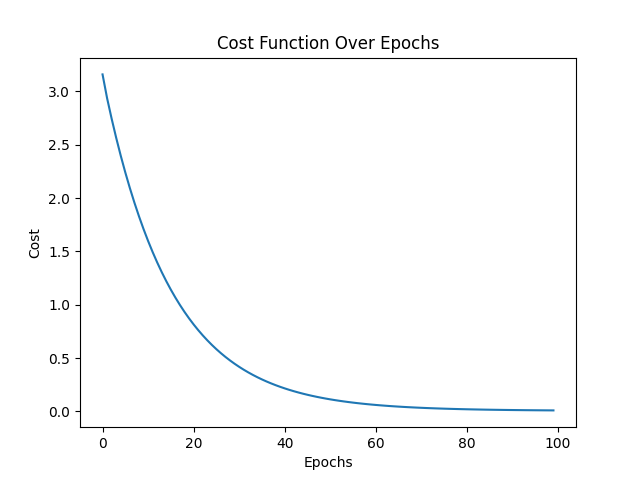

* EXO3

In [27]:
%%file genereux_akotenou2/exo3.py

# Import requirements
import numpy as np
from scipy.sparse import lil_matrix
from numpy.random import rand, seed
from numpy import array, concatenate
from mpi4py import MPI

# Initialize shared comm utils
COMM     = MPI.COMM_WORLD
nbOfproc = COMM.Get_size()
RANK     = COMM.Get_rank()
seed(42)

def matrixVectorMult(A, b, x):
    row, col = A.shape
    for i in range(row):
        a = A[i]
        for j in range(col):
            x[i] += a[j] * b[j]
    return 0

########################initialize matrix A and vector b ######################
SIZE = 1000
q, r = divmod(SIZE, nbOfproc)
Local_size = np.full(nbOfproc, q, dtype=int)
Local_size[:r] += 1
counts = [SIZE*row_count for row_count in Local_size]

if RANK == 0:   
    #A = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]], dtype=np.float64)
    #b = np.array([1, 1, 1])
    A = lil_matrix((SIZE, SIZE))
    A[0, :100] = rand(100)
    A[1, 100:200] = A[0, :100]
    A.setdiag(rand(SIZE))
    A = A.toarray()
    A = array(A)
    b = rand(SIZE)
else :
    A = array([])
    b = None

#####Send b to all procs and scatter A (each proc has its own local matrix#####
b = COMM.bcast(b, root=0)
LocalMatrix = np.zeros((Local_size[RANK], SIZE), dtype=np.float64)
COMM.Scatterv([A, counts, MPI.DOUBLE], recvbuf=LocalMatrix, root=0)

#####################Compute A*b locally#######################################
LocalX = np.zeros(LocalMatrix.shape[0])
start = MPI.Wtime()
matrixVectorMult(LocalMatrix, b, LocalX)
stop = MPI.Wtime()
exec_time = COMM.reduce((stop - start)*1000, op=MPI.MAX, root=0)

#####################Save execurtion time######################################
if RANK == 0:
    print("CPU time of parallel multiplication is ", exec_time)
    with open('exec_time_records.txt', 'a') as f:
        f.write(f"{nbOfproc}, {exec_time}\n")

##################Gather te results ###########################################
X = COMM.gather(LocalX, root=0)

##################Print the results ############################################
if RANK == 0 :
    X = concatenate(X)
    X_ = A.dot(b)
    #print("The result of A*b using dot is :", X_)
    print("The result of A*b using dot is :", np.max(X_ - X))
    #print("The result of A*b using parallel version is :", X)

Overwriting genereux_akotenou2/exo3.py


In [ ]:
!mpirun -n 2 python3 genereux_akotenou2/exo3.py

In [7]:
# OUTPUT
# % mpirun -n 2 python3 exo3.py
#
# CPU time of parallel multiplication is  49.074
# The result of A*b using dot is : 0.0

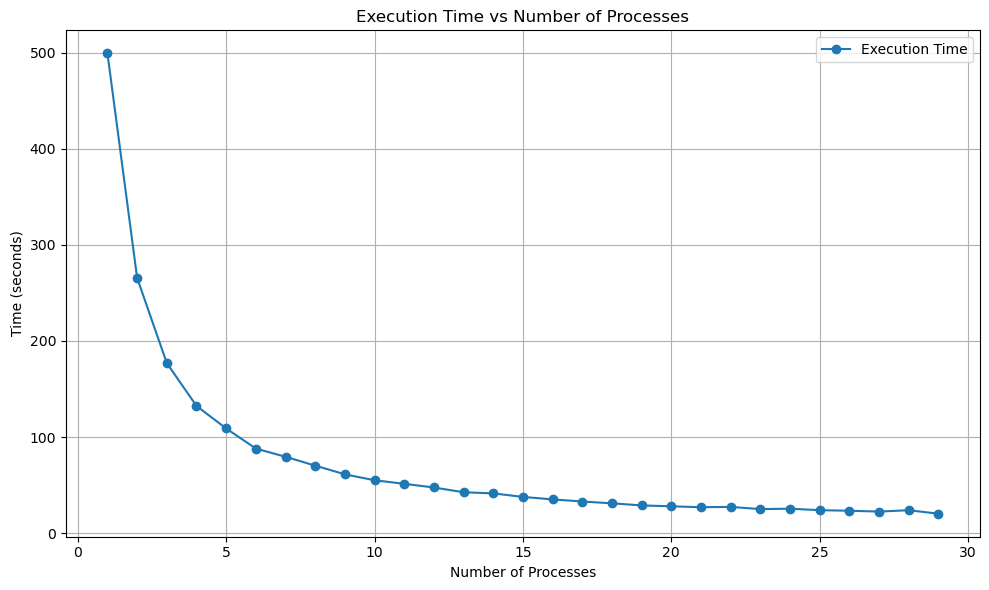

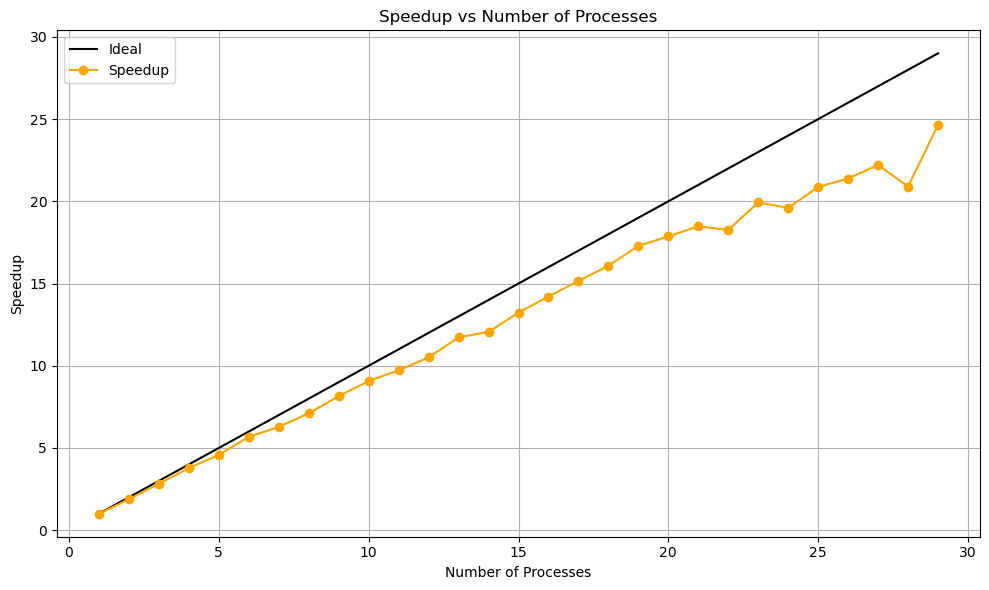

In [30]:
# EXO3 - PLOT SCALABILITY

import numpy as np
import matplotlib.pyplot as plt

# Record
data = """1, 499.162944
2, 265.520314
3, 176.880758
4, 132.39003699999998
5, 108.916061
6, 88.011908
7, 79.467739
8, 70.283758
9, 61.224503
10, 55.047439
11, 51.342068999999995
12, 47.51912
13, 42.574220000000004
14, 41.384319000000005
15, 37.730298000000005
16, 35.127325
17, 32.934315
18, 31.044602000000033
19, 28.872258000000002
20, 27.937580999999998
21, 27.009382
22, 27.340294
23, 25.040786999999998
24, 25.472049
25, 23.914153
26, 23.338725
27, 22.474709
28, 23.884463
29, 20.253200999999997"""

# Process
lines = data.split('\n')
num_processes = []
execution_time = []
for line in lines:
    line_data = line.split(',')
    num_processes.append(int(line_data[0]))
    execution_time.append(float(line_data[1]))

# Calculating speedup
sequential_time = execution_time[0]
speedup = [sequential_time / t for t in execution_time]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(num_processes, execution_time, marker='o', label='Execution Time')
plt.title('Execution Time vs Number of Processes')
plt.xlabel('Number of Processes')
plt.ylabel('Time (seconds)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(num_processes, num_processes, label='Ideal', color="black")
plt.plot(num_processes, speedup, marker='o', label='Speedup', color="orange")
plt.title('Speedup vs Number of Processes')
plt.xlabel('Number of Processes')
plt.ylabel('Speedup')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()